<a href="https://colab.research.google.com/github/Fet-elena/proba/blob/main/Fetisova_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

import pickle
import time
import os

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
os.environ['WANDB_DISABLED'] = 'true'
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import datetime

In [2]:
film = pd.read_csv('wiki_movie_plots_deduped.csv')
film

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...
...,...,...,...,...,...,...,...,...
34881,2014,The Water Diviner,Turkish,Director: Russell Crowe,Director: Russell Crowe\r\nCast: Russell Crowe...,unknown,https://en.wikipedia.org/wiki/The_Water_Diviner,"The film begins in 1919, just after World War ..."
34882,2017,Çalgı Çengi İkimiz,Turkish,Selçuk Aydemir,"Ahmet Kural, Murat Cemcir",comedy,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the..."
34883,2017,Olanlar Oldu,Turkish,Hakan Algül,"Ata Demirer, Tuvana Türkay, Ülkü Duru",comedy,https://en.wikipedia.org/wiki/Olanlar_Oldu,"Zafer, a sailor living with his mother Döndü i..."
34884,2017,Non-Transferable,Turkish,Brendan Bradley,"YouTubers Shanna Malcolm, Shira Lazar, Sara Fl...",romantic comedy,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...


In [3]:
film['Count']=1
film[['Genre','Count']].groupby(['Genre'], as_index=False).count().shape[0]
TotalCountGenres_1=sum(film['Count'])
total_counts = film.shape[0]
genre_counts = film['Genre'].value_counts()
print('total movies:',TotalCountGenres_1,'unique genre',len(film['Genre'].unique()),film['Genre'].unique())
film.describe()

total movies: 34886 unique genre 2265 ['unknown' 'western' 'comedy' ... 'adventure, romance, fantasy film' 'ero'
 'horror romantic comedy']


,Release Year,Count
count,34886.000000,34886.0
mean,1981.314252,1.0
std,27.815174,0.0
min,1901.000000,1.0
25%,1957.000000,1.0
50%,1988.000000,1.0
75%,2007.000000,1.0
max,2017.000000,1.0


# ***Построим гистограмму по национальным принадлежностям фильмов***

---



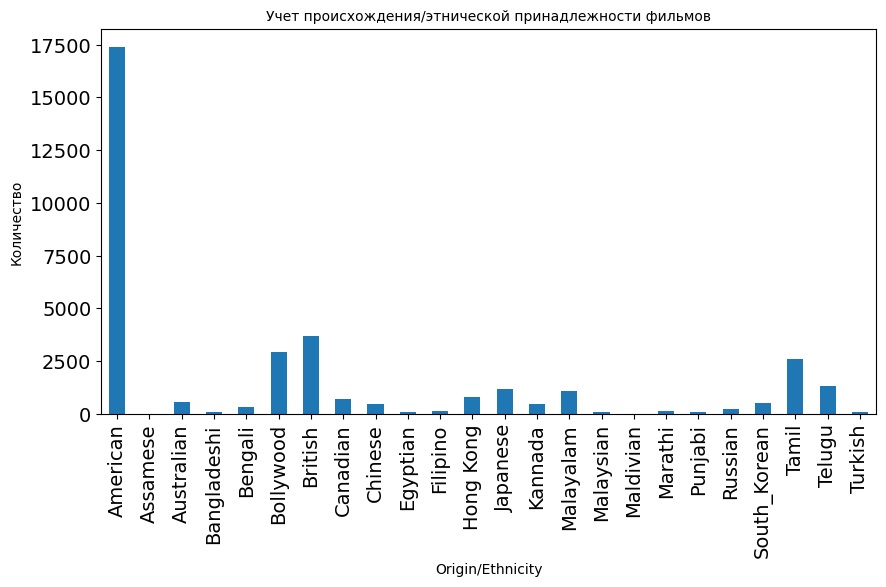

In [4]:
ax = film['Origin/Ethnicity'].value_counts().sort_index().plot.bar(
    figsize = (10, 5),
    fontsize = 14)

ax.set_title("Учет происхождения/этнической принадлежности фильмов", fontsize=10)
plt.xlabel('Origin/Ethnicity', fontsize=10)
plt.ylabel('Количество', fontsize=10)
plt.show()

# **Построим гистограмму по национальным принадлежностям фильмов, выпущенных в 21 веке**

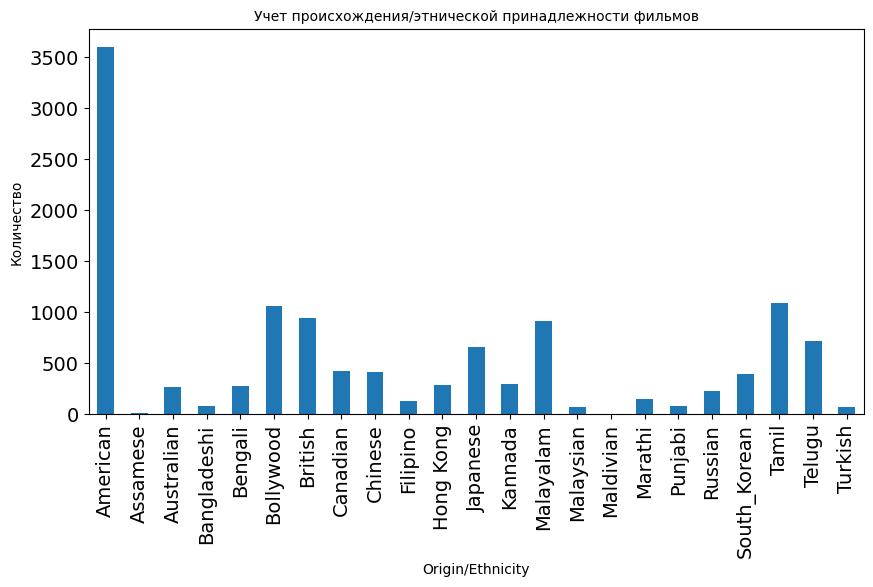

In [5]:
film_new = film[film['Release Year']>2000]. copy ()
ax = film_new['Origin/Ethnicity'].value_counts().sort_index().plot.bar(
    figsize = (10, 5),
    fontsize = 14)

ax.set_title("Учет происхождения/этнической принадлежности фильмов", fontsize=10)
plt.xlabel('Origin/Ethnicity', fontsize=10)
plt.ylabel('Количество', fontsize=10)
plt.show()

**Вывод**: наибольшее количество фильмов - американские. В 21 веке практически в два раза превышает число фильмов, произведенных в США, чем в Индии. Между тем, многие признают, что у индийской киноиндустрии большое будущее. Главное преимущество Болливуда заключается в верности традиции

In [6]:
# сгруппируем данные по годам для наглядной вмзуализации
def year (x):
  if x > 1900 and x < 1950:
    return '1900-1949'
  else:
    if x >= 1950 and x < 1955:
      return '1950-1954'
    else:
      if x >= 1955 and x < 1960:
         return '1950-1959'
      else:
        if x >= 1960 and x < 1964:
          return '1960-1964'
        else:
          if x >= 1965 and x < 1970:
            return '1965-1969'
          else:
            if x >= 1970 and x < 1975:
              return '1970-1974'
            else:
              if x >= 1975 and x < 1980:
                return '1975-1979'
              else:
                if x >= 1980 and x < 1985:
                  return '1980-1984'
                else:
                  if x >= 1985 and x < 1990:
                    return '1985-1989'
                  else:
                    if x >= 1990 and x < 1995:
                      return '1990-1994'
                    else:
                      if x >= 1995 and x < 2000:
                        return '1995-1999'
                      else:
                        if x >= 2000 and x < 2005:
                          return '2000-2004'
                        else:
                          if x >= 2005 and x < 2010:
                            return '2005-2009'
                          else:
                            if x >= 2010 and x < 2015:
                             return '2010-2014'
                            else:
                              return '2015-2017'


film['Release Year_5'] = film['Release Year'].apply(year)

# **Построим гистограмму по количеству фильмов, выпущенных в определенный год**

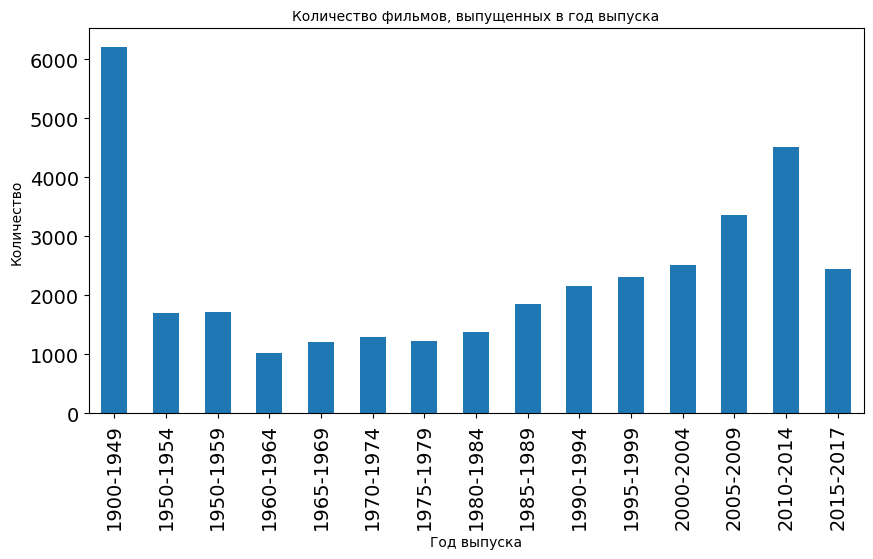

In [7]:
ax = film['Release Year_5'].value_counts().sort_index().plot.bar(
    figsize = (10, 5),
    fontsize = 14)

film['Release Year_5']
ax.set_title("Количество фильмов, выпущенных в год выпуска", fontsize=10)
plt.xlabel('Год выпуска', fontsize=10)
plt.ylabel('Количество', fontsize=10)
#sns.despine(bottom=True, left=True)
plt.show()

*Вывод*: В первую половину прошлого столетия было выпущено фильмов по количеству примерно равное количеству снятому в последующие два десятилетия. И только, начиная с 80 годов выпуск фильмов начинает увеличиваться. Каждые пять последующих лет растет в арифметической проогресии.

# **Построим гистограмму по режиссерам фильмов**

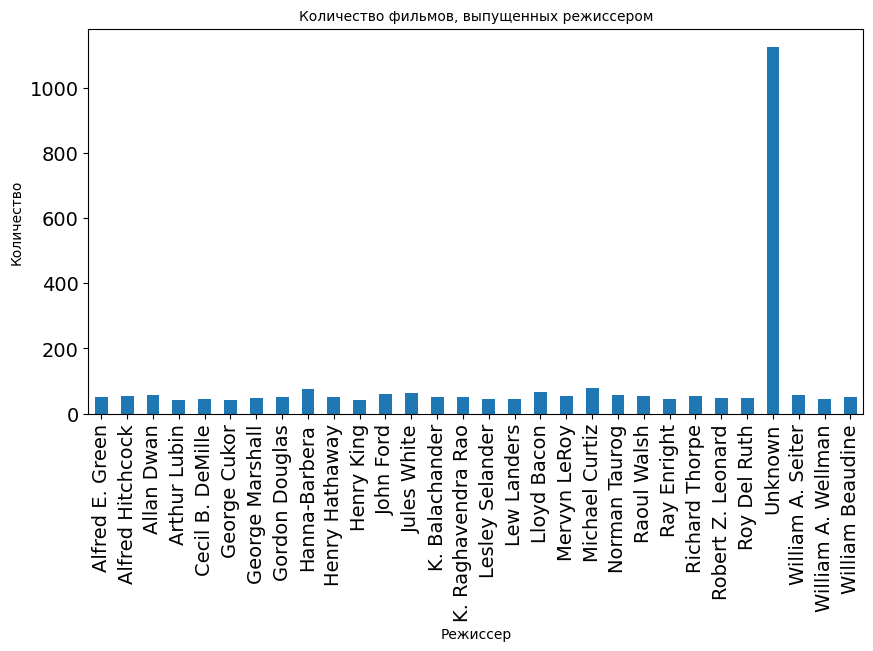

In [8]:
ax = film['Director'].value_counts().head(30).sort_index().plot.bar(
    figsize = (10, 5),
    fontsize = 14)

ax.set_title("Количество фильмов, выпущенных режиссером", fontsize=10)
plt.xlabel('Режиссер', fontsize=10)
plt.ylabel('Количество', fontsize=10)
#sns.despine(bottom=True, left=True)
plt.show()

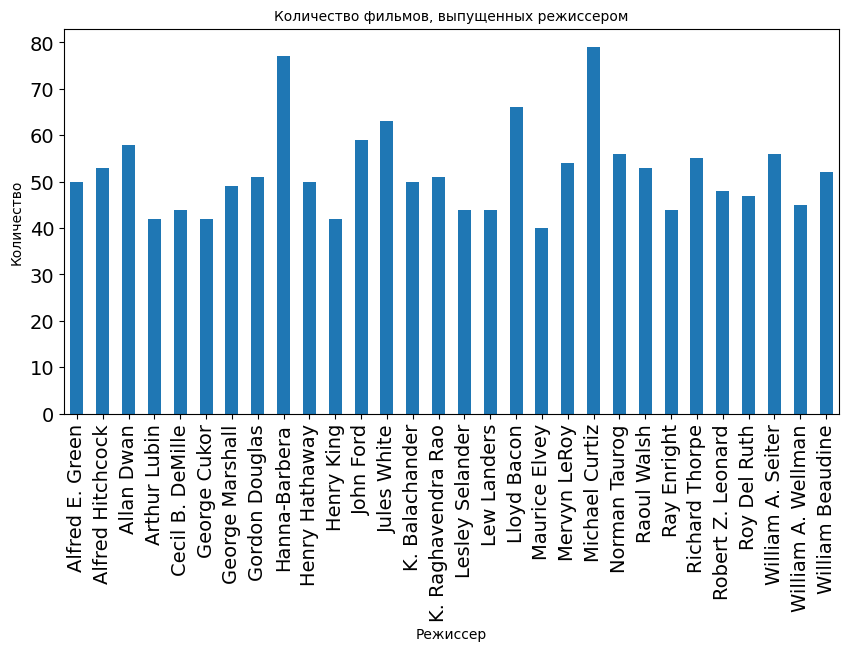

In [9]:
# построим гистограмму без учета неизвестных режиссеров
film_new_1 = film[film['Director']!='Unknown']. copy ()
ax = film_new_1['Director'].value_counts().head(30).sort_index().plot.bar(
    figsize = (10, 5),
    fontsize = 14)

ax.set_title("Количество фильмов, выпущенных режиссером", fontsize=10)
plt.xlabel('Режиссер', fontsize=10)
plt.ylabel('Количество', fontsize=10)
#sns.despine(bottom=True, left=True)
plt.show()

Вывод: Большое количество фильмов в базе данных без указания режиссера.
Из режиссеров, выпустивших наибольшее количество фильмов, выделяются Hanna-Barbera и Michael Curtiz.

**Построим гистограмму по жанрам фильмов**

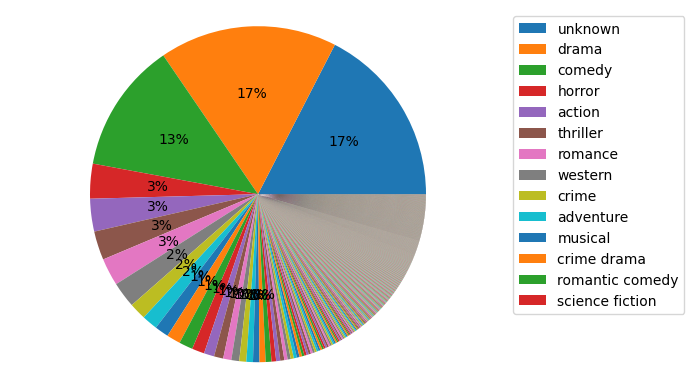

In [10]:
# построим гистограмму на имеющихся данных

sizes = pd.DataFrame(genre_counts.values/total_counts, index = genre_counts.index)

fig1, ax = plt.subplots()
def autopct_more_than_1(pct):
    return ('%1.f%%' % pct) if pct > 0.5 else ''

p,t,a = ax.pie(sizes.values.reshape(1,-1)[0], autopct=autopct_more_than_1)
ax.axis('equal')

# normalize dataframe (not actually needed here, but for general case)
normsizes = sizes/sizes.sum()*100
# create handles and labels for legend, take only those where value is > 1
h,l = zip(*[(h,lab) for h,lab,i in zip(p,sizes.index.values,normsizes.values) if i > 1])

ax.legend(h, l,loc="best", bbox_to_anchor=(1,1))
plt.show()

Вывод: много мусора

In [11]:
# почистим жанры
# удаляем символы
sympols=set()
film['Genre']=film['Genre'].str.strip()

for i in film['Genre'] :
    for char in i :
        if not re.fullmatch(r'[a-zA-Z]', char) is not None and not char in sympols:
            sympols.add(char)
            film['Genre']=film['Genre'].str.replace(char,' ')
film['Genre']=film['Genre'].str.replace('  ',' ')
film['Genre']=film['Genre'].str.replace('   ',' ')
film['Genre']=film['Genre'].str.replace('    ',' ')
film['Genre']=film['Genre'].str.replace('    ',' ')
film['Genre']=film['Genre'].str.replace('    ',' ')

In [12]:

film["Genre"] = film["Genre"].str.replace(u"\xa0", " ", regex=False)
film["Genre"] = film["Genre"].str.strip()

# Удалим сноски
film["Genre"] = film.Genre.str.replace("\s*\[.*\]", "", regex=True)

# Корректируем далее
film["Genre"] = film["Genre"].str.replace("–|—", "-", regex=True)
film.loc[film.Genre.isin(["-", ""]), "Genre"] = "unknown"

# Завершающая пунктуация
film["Genre"] = film["Genre"].str.replace("[.,;\s]+$", "", regex=True)

# Явно не жанры
film["Genre"] = film["Genre"].str.replace(
    "(warner bros|paramount|united artists)\. ", "", regex=True
)
film["Genre"] = film["Genre"].str.replace("(co-)?produced .*$", "", regex=True)
film["Genre"] = film["Genre"].str.replace('spy spoof|spoof', "unknown")

film.loc[film.Genre.str.contains("films$"), "Genre"] = "unknown"
film["Genre"] = film["Genre"].str.replace("\s*film\s*", "", regex=True)

# на чем основан этот фильм
film["Genre"] = film["Genre"].str.replace(" (about|based on).*$", "", regex=True)

# или информация в круглых скобках
film["Genre"] = film["Genre"].str.replace(r"\s*\(.*?\)\s*", "", regex=True)

# Разные названия имеют одно и то же значение
film["Genre"] = film["Genre"].str.replace("3-d", "3d", regex=False)
film["Genre"] = film["Genre"].str.replace("science[- ]fiction", "sci-fi", regex=True)
film["Genre"] = film["Genre"].str.replace("sci fi", "sci-fi", regex=False)
film["Genre"] = film["Genre"].str.replace(r"bio-?pic", "biographical", regex=True)
film["Genre"] = film["Genre"].str.replace("biography", "biographical", regex=False)
film["Genre"] = film["Genre"].str.replace("ww|(world war)", " worldwar", regex=True)
film["Genre"] = film["Genre"].str.replace(r"(kung|gun)( |-)fu", "kungfu", regex=True)
film["Genre"] = film["Genre"].str.replace("007", "james bond", regex=False)
film["Genre"] = film["Genre"].str.replace(
    r"rom(antic|ance)? com(edy)?", "rom-com", regex=True
)
film["Genre"] = film["Genre"].str.replace(
    r"(action|comedy|horror) masala", r"\1 | masala", regex=True
)

# Опечатки
film["Genre"] = film["Genre"].str.replace("family. ", "family | ", regex=False)
film["Genre"] = film["Genre"].str.replace("familya", "family", regex=False)
film["Genre"] = film["Genre"].str.replace("supeheroes", "superheroes", regex=False)
film["Genre"] = film["Genre"].str.replace(r" in 3d.?", ", 3d", regex=True)
film["Genre"]=film["Genre"].str.replace('family','children')
film["Genre"]=film["Genre"].str.replace('martial_arts','action')
film["Genre"]=film["Genre"].str.replace('horror','thriller')
film["Genre"]=film["Genre"].str.replace('war','action')
film["Genre"]=film["Genre"].str.replace('adventure','action')
film["Genre"]=film["Genre"].str.replace('science_fiction','action')
film["Genre"]=film["Genre"].str.replace('western','action')
film["Genre"]=film["Genre"].str.replace('western','action')
film["Genre"]=film["Genre"].str.replace('noir','black')
film["Genre"]=film["Genre"].str.replace('spy','action')
film["Genre"]=film["Genre"].str.replace('superhero','action')
film["Genre"]=film["Genre"].str.replace('social','drama')
film["Genre"]=film["Genre"].str.replace('suspense','action')
film["Genre"]=film["Genre"].str.replace('musical','music')
film["Genre"]=film["Genre"].str.replace('animated','animation')
film["Genre"]=film["Genre"].str.replace('anime','animation')
film["Genre"]=film["Genre"].str.replace('rom-com','romance|comedy')
film["Genre"]=film["Genre"].str.replace('ii','unknown')
film["Genre"]=film["Genre"].str.replace('tokusatsu','unknown')
film["Genre"]=film["Genre"].str.replace("sci-fi",'ScienceFiction')
film["Genre"]=film["Genre"].str.replace('melodrama','drama')
film["Genre"]=film["Genre"].str.replace('romantic','romance')
film["Genre"]=film["Genre"].str.replace('worldaction','action')
for i in film['Genre'] :
    if 'war' in i :
        film["Genre"]=film["Genre"].str.replace(i,'action')
# Особые случаи
film.loc[film.Title == "Tales of Manhattan", "Genre"] = "drama | comedy"
film.loc[film.Title == "Aaram", "Genre"] = "romance"
film.loc[film.Title == "Roadside Attractions", "Genre"] = "comedy | drama"

# Сепараторы
film["Genre"] = film["Genre"].str.replace(' ','|')
film["Genre"] = film["Genre"].str.replace(r"\s*([;,/]| and )\s*", " | ", regex=True)
film["Genre"] = film["Genre"].str.replace(r"\s+[&-]\s+", " | ", regex=True)
film["Genre"] = film["Genre"].str.replace(r"( \| )+$", "", regex=True)

################
film['Count']=1
len(film['Genre'].unique())

def sort_unique(genre):
    if len(genre) > 1:
        return np.sort(np.unique(genre))
    else:
        return genre

film['GenreSplit'] = film['Genre'].apply(lambda x: x.strip().split('|'))
film['GenreSplit'] = film['GenreSplit'].apply(sort_unique)
genres_array = np.array([])

for i in range(0,film.shape[0]-1):
    genres_array = np.concatenate((genres_array, film['GenreSplit'][i] ))

genres_array
genres = pd.DataFrame({'Genre':genres_array})

genres['Count']=1
print(genres[['Genre','Count']].groupby(['Genre'], as_index=False).sum().sort_values(['Count'], ascending=False).shape[0])
genres = genres[genres['Genre']!='']

602


In [13]:
genres=genres[['Genre','Count']].groupby(['Genre'], as_index=False).sum().sort_values(['Count'], ascending=False)
genres = genres[genres['Genre']!='']
TotalCountGenres=sum(genres['Count'])
genres['Frequency'] = genres['Count']/TotalCountGenres
genres['CumulativeFrequency'] = genres['Frequency'].cumsum()
genres[['Genre','Frequency','CumulativeFrequency']].groupby(['Genre'], as_index=False).sum().sort_values(['Frequency'], ascending=False).shape[0]
mainGenres=np.array(genres[genres['CumulativeFrequency']<=.95]['Genre'])
genres[['Genre','Count','Frequency','CumulativeFrequency']].head(30)

,Genre,Count,Frequency,CumulativeFrequency
165,drama,9570,0.216242,0.216242
122,comedy,7282,0.164543,0.380785
575,unknown,6257,0.141382,0.522166
3,action,5022,0.113476,0.635643
555,thriller,3287,0.074272,0.709915
454,romance,2637,0.059585,0.769500
134,crime,1605,0.036266,0.805766
339,music,964,0.021782,0.827549
0,ScienceFiction,951,0.021489,0.849037
33,animation,909,0.020540,0.869577


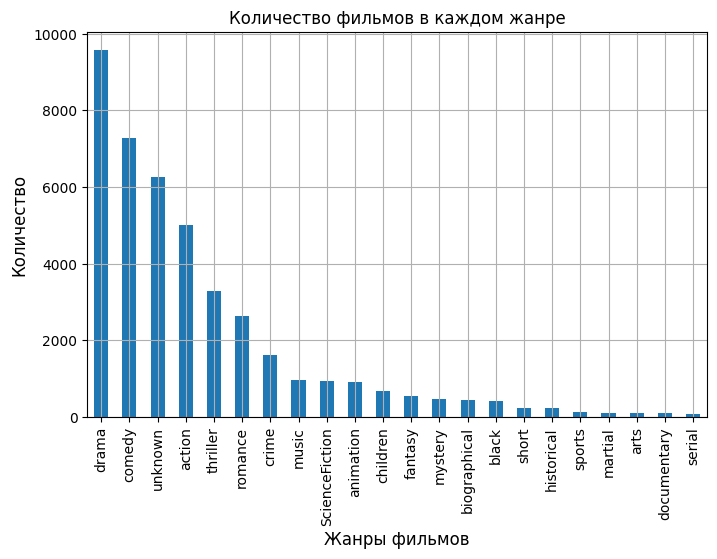

In [14]:
genres[genres['CumulativeFrequency']<=.95][['Genre','Count']].plot(x='Genre', y='Count', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Количество фильмов в каждом жанре")
plt.ylabel('Количество', fontsize=12)
plt.xlabel('Жанры фильмов', fontsize=12)
plt.show()

**Вывод**: больше всего выпускают драмы и комедии. Наименее популярны - документальные.

# Sentiment analysis


In [15]:
film

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,Count,Release Year_5,GenreSplit
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr...",1,1900-1949,[unknown]
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov...",1,1900-1949,[unknown]
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed...",1,1900-1949,[unknown]
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...,1,1900-1949,[unknown]
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...,1,1900-1949,[unknown]
...,...,...,...,...,...,...,...,...,...,...,...
34881,2014,The Water Diviner,Turkish,Director: Russell Crowe,Director: Russell Crowe\r\nCast: Russell Crowe...,unknown,https://en.wikipedia.org/wiki/The_Water_Diviner,"The film begins in 1919, just after World War ...",1,2010-2014,[unknown]
34882,2017,Çalgı Çengi İkimiz,Turkish,Selçuk Aydemir,"Ahmet Kural, Murat Cemcir",comedy,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the...",1,2015-2017,[comedy]
34883,2017,Olanlar Oldu,Turkish,Hakan Algül,"Ata Demirer, Tuvana Türkay, Ülkü Duru",comedy,https://en.wikipedia.org/wiki/Olanlar_Oldu,"Zafer, a sailor living with his mother Döndü i...",1,2015-2017,[comedy]
34884,2017,Non-Transferable,Turkish,Brendan Bradley,"YouTubers Shanna Malcolm, Shira Lazar, Sara Fl...",romance|comedy,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...,1,2015-2017,"[comedy, romance]"


In [16]:
!pip install nltk
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [17]:
from tkinter.constants import NONE
def sent_func(x):
    sentiments = sia.polarity_scores(x)
    best_key = None
    best_value = None
    for key, value in sentiments.items():
        #if key == "compound" or key == "neu":
        if key == "compound":

            continue
        if best_key is None or value > best_value:
            best_key = key
            best_value = value
    return best_key


## Построим прогноз настроения сюжета по его описанию.

In [18]:
film["plot_sentiment"] = film.Plot.apply(sent_func)

In [19]:
film.plot_sentiment.value_counts()

plot_sentiment
neu    34866
neg       16
pos        4
Name: count, dtype: int64

Получилось, что большинство сюжетов (34866) - нейтральные по эмоциональному окрасу. 16 - негативных, 4 - позитивных. Вывод логичный, так как чаще всего краткие описания сюжетов фильмов не содержат какого-то отношения автора к объекту высказывания.

## Построим прогноз настроения отзывов к фильмам.

Добавим датасет с отзывами фильмов с Rotten Tomatoes

In [20]:
# отзывы
reviews = pd.read_csv('rotten_tomatoes_movie_reviews.csv')
reviews

,id,reviewId,creationDate,criticName,isTopCritic,originalScore,reviewState,publicatioName,reviewText,scoreSentiment,reviewUrl
0,beavers,1145982,2003-05-23,Ivan M. Lincoln,False,3.5/4,fresh,Deseret News (Salt Lake City),Timed to be just long enough for most youngste...,POSITIVE,http://www.deseretnews.com/article/700003233/B...
1,blood_mask,1636744,2007-06-02,The Foywonder,False,1/5,rotten,Dread Central,It doesn't matter if a movie costs 300 million...,NEGATIVE,http://www.dreadcentral.com/index.php?name=Rev...
2,city_hunter_shinjuku_private_eyes,2590987,2019-05-28,Reuben Baron,False,NaN,fresh,CBR,The choreography is so precise and lifelike at...,POSITIVE,https://www.cbr.com/city-hunter-shinjuku-priva...
3,city_hunter_shinjuku_private_eyes,2558908,2019-02-14,Matt Schley,False,2.5/5,rotten,Japan Times,The film's out-of-touch attempts at humor may ...,NEGATIVE,https://www.japantimes.co.jp/culture/2019/02/0...
4,dangerous_men_2015,2504681,2018-08-29,Pat Padua,False,NaN,fresh,DCist,Its clumsy determination is endearing and some...,POSITIVE,http://dcist.com/2015/11/out_of_frame_dangerou...
...,...,...,...,...,...,...,...,...,...,...,...
1444958,thor_love_and_thunder,102706151,2022-07-05,Christie Cronan,False,7/10,fresh,Raising Whasians,Solid but not totally sold&#44; Thor&#58; Ragn...,POSITIVE,https://raisingwhasians.com/thor-love-and-thun...
1444959,thor_love_and_thunder,102706150,2022-07-05,Ian Sandwell,False,4/5,fresh,Digital Spy,Thor&#58; Love and Thunder is the most enterta...,POSITIVE,https://www.digitalspy.com/movies/a40496050/th...
1444960,thor_love_and_thunder,102706149,2022-07-05,Lauren LaMagna,False,8/10,fresh,Next Best Picture,&quot;Thor&#58; Love and Thunder&quot; is a st...,POSITIVE,https://www.nextbestpicture.com/thor-love-and-...
1444961,thor_love_and_thunder,102706148,2022-07-05,Jake Cole,True,1/4,rotten,Slant Magazine,Across Taika Waititi&#8217;s film&#44; a war a...,NEGATIVE,https://www.slantmagazine.com/film/thor-love-a...


In [21]:
#таблица с id и названиями фильмов
film_name = pd.read_csv('rotten_tomatoes_movies.csv')
film_name

,id,title,audienceScore,tomatoMeter,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,writer,boxOffice,distributor,soundMix
0,space-zombie-bingo,Space Zombie Bingo!,50.0,NaN,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,George Ormrod,"George Ormrod,John Sabotta",NaN,NaN,NaN
1,the_green_grass,The Green Grass,NaN,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Tiffany Edwards,Tiffany Edwards,NaN,NaN,NaN
2,love_lies,"Love, Lies",43.0,NaN,NaN,NaN,NaN,NaN,120.0,Drama,Korean,"Park Heung-Sik,Heung-Sik Park","Ha Young-Joon,Jeon Yun-su,Song Hye-jin",NaN,NaN,NaN
3,the_sore_losers_1997,Sore Losers,60.0,NaN,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,John Michael McCarthy,John Michael McCarthy,NaN,NaN,NaN
4,dinosaur_island_2002,Dinosaur Island,70.0,NaN,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Will Meugniot,John Loy,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143253,nadia_the_secret_of_blue_water_the_motion_pict...,Nadia: The Secret of Blue Water: The Motion Pi...,14.0,NaN,NaN,NaN,2002-08-27,NaN,90.0,"Action, Adventure, Anime",Japanese,Sho Aono,Kaoru Umeno,NaN,ADV Films,NaN
143254,everyone_i_knew_and_loved,Everyone I Knew and Loved,NaN,NaN,NaN,NaN,NaN,NaN,99.0,Drama,English,Andrew Behringer,Erika Heidewald,NaN,NaN,NaN
143255,the-human-body,The Human Body,71.0,89.0,NaN,NaN,NaN,NaN,43.0,Documentary,English,Peter Georgi,Richard Dale,NaN,NaN,NaN
143256,flying_fists,Flying Fists,NaN,NaN,NaN,NaN,NaN,2006-11-21,63.0,Drama,English,Robert F. Hill,"Robert F. Hill,Basil Dickey",NaN,NaN,NaN


In [22]:
# Объединяем таблицу с отзывами и таблицу с названиями и id фильмов, чтобы получить названия

reviews = pd.merge(reviews, film_name, on = 'id', how = 'inner')[['title', 'reviewText']]
reviews

,title,reviewText
0,Beavers,Timed to be just long enough for most youngste...
1,Blood Mask,It doesn't matter if a movie costs 300 million...
2,City Hunter: Shinjuku Private Eyes,The choreography is so precise and lifelike at...
3,City Hunter: Shinjuku Private Eyes,The film's out-of-touch attempts at humor may ...
4,Dangerous Men,Its clumsy determination is endearing and some...
...,...,...
1469538,Thor: Love and Thunder,Solid but not totally sold&#44; Thor&#58; Ragn...
1469539,Thor: Love and Thunder,Thor&#58; Love and Thunder is the most enterta...
1469540,Thor: Love and Thunder,&quot;Thor&#58; Love and Thunder&quot; is a st...
1469541,Thor: Love and Thunder,Across Taika Waititi&#8217;s film&#44; a war a...


In [23]:
# Объединяем таблицу с прошлого этапа и начальную таблицу с фильмами по названию, чтобы получить отзывы по фильмам в исходной таблице

data = pd.merge(reviews, film, left_on = 'title', right_on = 'Title', how = 'inner')
data

,title,reviewText,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,Count,Release Year_5,GenreSplit,plot_sentiment
0,Death of a Salesman,"Miller has taken a small, intimate tale and ex...",1951,Death of a Salesman,American,László Benedek,"Fredric March, Mildred Dunnock",drama,https://en.wikipedia.org/wiki/Death_of_a_Sales...,Willy Loman has led a life consisting of 60 ye...,1,1950-1954,[drama],neu
1,Death of a Salesman,A classic American tragedy.,1951,Death of a Salesman,American,László Benedek,"Fredric March, Mildred Dunnock",drama,https://en.wikipedia.org/wiki/Death_of_a_Sales...,Willy Loman has led a life consisting of 60 ye...,1,1950-1954,[drama],neu
2,Death of a Salesman,NaN,1951,Death of a Salesman,American,László Benedek,"Fredric March, Mildred Dunnock",drama,https://en.wikipedia.org/wiki/Death_of_a_Sales...,Willy Loman has led a life consisting of 60 ye...,1,1950-1954,[drama],neu
3,Death of a Salesman,NaN,1951,Death of a Salesman,American,László Benedek,"Fredric March, Mildred Dunnock",drama,https://en.wikipedia.org/wiki/Death_of_a_Sales...,Willy Loman has led a life consisting of 60 ye...,1,1950-1954,[drama],neu
4,Death of a Salesman,"Death of a Salesman, directed by Volker Schlon...",1951,Death of a Salesman,American,László Benedek,"Fredric March, Mildred Dunnock",drama,https://en.wikipedia.org/wiki/Death_of_a_Sales...,Willy Loman has led a life consisting of 60 ye...,1,1950-1954,[drama],neu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858164,Sex and the City,Will give female audiences a jolt of excitemen...,2008,Sex and the City,American,Michael Patrick King,"Sarah Jessica Parker, Kim Cattrall, Kristin Da...",comedy,https://en.wikipedia.org/wiki/Sex_and_the_City...,Carrie walks through the streets of New York C...,1,2005-2009,[comedy],neu
858165,Sex and the City,The end product is a case of bigger not necess...,2008,Sex and the City,American,Michael Patrick King,"Sarah Jessica Parker, Kim Cattrall, Kristin Da...",comedy,https://en.wikipedia.org/wiki/Sex_and_the_City...,Carrie walks through the streets of New York C...,1,2005-2009,[comedy],neu
858166,Sex and the City,One thing's for sure: fans of the series will ...,2008,Sex and the City,American,Michael Patrick King,"Sarah Jessica Parker, Kim Cattrall, Kristin Da...",comedy,https://en.wikipedia.org/wiki/Sex_and_the_City...,Carrie walks through the streets of New York C...,1,2005-2009,[comedy],neu
858167,Sex and the City,"Yes, it's good to see the Fab Four together ag...",2008,Sex and the City,American,Michael Patrick King,"Sarah Jessica Parker, Kim Cattrall, Kristin Da...",comedy,https://en.wikipedia.org/wiki/Sex_and_the_City...,Carrie walks through the streets of New York C...,1,2005-2009,[comedy],neu


Получилось 858169 отзывов

In [24]:
data.title.nunique()

15558

В добавленном датасете совпали всего 15558 фиьмов из 35000 исходных, однако это достаточно для анализа отзывов (их и так 850.000)

Так как отзыв должен быть либо положительным, либо отрицательным, то уберем тип "нейтральный" из модели и посмотрим, как она предскажет, положительный отзыв или отрицательный

In [25]:
from tkinter.constants import NONE
def sent_func(x):
    sentiments = sia.polarity_scores(x)
    best_key = None
    best_value = None
    for key, value in sentiments.items():
        if key == "compound" or key == "neu":
        # if key == "compound":
            continue
        if best_key is None or value > best_value:
            best_key = key
            best_value = value
    return best_key


In [26]:
data = data[data['reviewText'].isnull() == False].astype('str')
data["review_sentiment"] = data.reviewText.apply(sent_func)
data.review_sentiment.value_counts()

review_sentiment
pos    479332
neg    323219
Name: count, dtype: int64

Получилось 480.000 положительных и 320.000 отрицательных отзывов.

## Посмотрим распределение по актерам, режиссерам и жанрам

In [27]:
data['positive_review'] = 0
data['positive_review'][data['review_sentiment'] == 'pos'] = 1

# Выберем режиссеров у которых больше 20 отзывов
df = data.groupby('Director', as_index = False).Title.count()
df = pd.merge(data, df, on = 'Director', how = 'inner').rename(columns = {'Title_x': 'Title', 'Title_y': 'review_on_director'})
df = df[df['review_on_director'] > 20]
df

<ipython-input-27-da45770717f0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['positive_review'][data['review_sentiment'] == 'pos'] = 1


,title,reviewText,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,Count,Release Year_5,GenreSplit,plot_sentiment,review_sentiment,positive_review,review_on_director
11,Sahara,&#46;&#46;&#46; what we get with &#8220;Sahara...,1919,Sahara,American,Arthur Rosson,"Louise Glaum, Matt Moore",drama,https://en.wikipedia.org/wiki/Sahara_(1919_film),"Silent film femme fatale, Louise Glaum, portra...",1,1900-1949,['drama'],neu,neg,0,177
12,Sahara,"Packed with pithy dialog, lusty action and sus...",1919,Sahara,American,Arthur Rosson,"Louise Glaum, Matt Moore",drama,https://en.wikipedia.org/wiki/Sahara_(1919_film),"Silent film femme fatale, Louise Glaum, portra...",1,1900-1949,['drama'],neu,neg,0,177
13,Sahara,Zoltan Korda's wartime coalition is more Air F...,1919,Sahara,American,Arthur Rosson,"Louise Glaum, Matt Moore",drama,https://en.wikipedia.org/wiki/Sahara_(1919_film),"Silent film femme fatale, Louise Glaum, portra...",1,1900-1949,['drama'],neu,neg,0,177
14,Sahara,"Like other WWII adventures, Sahara contains el...",1919,Sahara,American,Arthur Rosson,"Louise Glaum, Matt Moore",drama,https://en.wikipedia.org/wiki/Sahara_(1919_film),"Silent film femme fatale, Louise Glaum, portra...",1,1900-1949,['drama'],neu,pos,1,177
15,Sahara,Bogey's presence lends a hard-boiled nature to...,1919,Sahara,American,Arthur Rosson,"Louise Glaum, Matt Moore",drama,https://en.wikipedia.org/wiki/Sahara_(1919_film),"Silent film femme fatale, Louise Glaum, portra...",1,1900-1949,['drama'],neu,neg,0,177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802535,21 Jump Street,Lord and Miller have created an instant classi...,2012,21 Jump Street,American,Phil Lord and Chris Miller,"Jonah Hill, Channing Tatum, Brie Larson, Ice C...",action|comedy,https://en.wikipedia.org/wiki/21_Jump_Street_(...,"In 2005, scholarly student Morton Schmidt (Jon...",1,2010-2014,['action' 'comedy'],neu,pos,1,227
802536,21 Jump Street,Unpredictable and very silly but with real emo...,2012,21 Jump Street,American,Phil Lord and Chris Miller,"Jonah Hill, Channing Tatum, Brie Larson, Ice C...",action|comedy,https://en.wikipedia.org/wiki/21_Jump_Street_(...,"In 2005, scholarly student Morton Schmidt (Jon...",1,2010-2014,['action' 'comedy'],neu,pos,1,227
802537,21 Jump Street,Holding its middle finger up to '80s retro-hou...,2012,21 Jump Street,American,Phil Lord and Chris Miller,"Jonah Hill, Channing Tatum, Brie Larson, Ice C...",action|comedy,https://en.wikipedia.org/wiki/21_Jump_Street_(...,"In 2005, scholarly student Morton Schmidt (Jon...",1,2010-2014,['action' 'comedy'],neu,pos,1,227
802538,21 Jump Street,"It has a bad, slapstick first act but by midpo...",2012,21 Jump Street,American,Phil Lord and Chris Miller,"Jonah Hill, Channing Tatum, Brie Larson, Ice C...",action|comedy,https://en.wikipedia.org/wiki/21_Jump_Street_(...,"In 2005, scholarly student Morton Schmidt (Jon...",1,2010-2014,['action' 'comedy'],neu,neg,0,227


Построим долю хороших отзывов по топ-10 лучшим режиссерам и топ-10 худшим




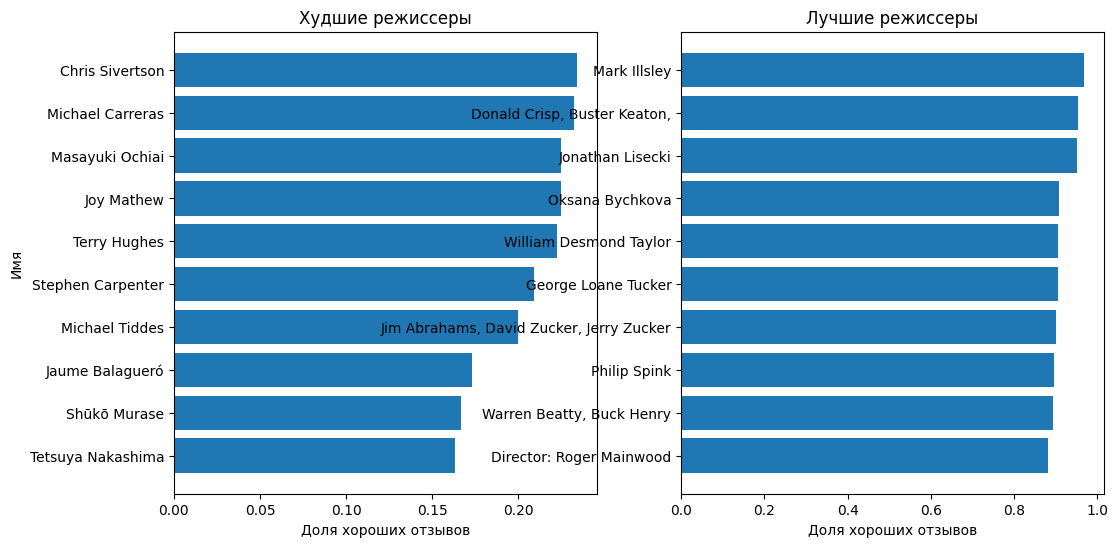

In [28]:
dir_best = df.groupby('Director').positive_review.mean().sort_values()[-10:]
dir_worst = df.groupby('Director').positive_review.mean().sort_values()[:10]

fig, axs = plt.subplots(1, 2, figsize =(12,6) )
axs[0].barh(dir_worst.index, dir_worst)
axs[0].set(title='Худшие режиссеры', ylabel= 'Имя', xlabel= 'Доля хороших отзывов')

axs[1].barh(dir_best.index, dir_best)
axs[1].set(title = 'Лучшие режиссеры', xlabel= 'Доля хороших отзывов', ylabel= '')

plt.show()

In [29]:
# Выберем актеров у которых больше 20 отзывов
df = data.groupby('Cast', as_index = False).Title.count()
df = pd.merge(data, df, on = 'Cast', how = 'inner').rename(columns = {'Title_x': 'Title', 'Title_y': 'review_on_cast'})
df = df[df['review_on_cast'] > 20]
df

,title,reviewText,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,Count,Release Year_5,GenreSplit,plot_sentiment,review_sentiment,positive_review,review_on_cast
10,Sahara,&#46;&#46;&#46; what we get with &#8220;Sahara...,1919,Sahara,American,Arthur Rosson,"Louise Glaum, Matt Moore",drama,https://en.wikipedia.org/wiki/Sahara_(1919_film),"Silent film femme fatale, Louise Glaum, portra...",1,1900-1949,['drama'],neu,neg,0,176
11,Sahara,"Packed with pithy dialog, lusty action and sus...",1919,Sahara,American,Arthur Rosson,"Louise Glaum, Matt Moore",drama,https://en.wikipedia.org/wiki/Sahara_(1919_film),"Silent film femme fatale, Louise Glaum, portra...",1,1900-1949,['drama'],neu,neg,0,176
12,Sahara,Zoltan Korda's wartime coalition is more Air F...,1919,Sahara,American,Arthur Rosson,"Louise Glaum, Matt Moore",drama,https://en.wikipedia.org/wiki/Sahara_(1919_film),"Silent film femme fatale, Louise Glaum, portra...",1,1900-1949,['drama'],neu,neg,0,176
13,Sahara,"Like other WWII adventures, Sahara contains el...",1919,Sahara,American,Arthur Rosson,"Louise Glaum, Matt Moore",drama,https://en.wikipedia.org/wiki/Sahara_(1919_film),"Silent film femme fatale, Louise Glaum, portra...",1,1900-1949,['drama'],neu,pos,1,176
14,Sahara,Bogey's presence lends a hard-boiled nature to...,1919,Sahara,American,Arthur Rosson,"Louise Glaum, Matt Moore",drama,https://en.wikipedia.org/wiki/Sahara_(1919_film),"Silent film femme fatale, Louise Glaum, portra...",1,1900-1949,['drama'],neu,neg,0,176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802546,Sex and the City,Will give female audiences a jolt of excitemen...,2008,Sex and the City,American,Michael Patrick King,"Sarah Jessica Parker, Kim Cattrall, Kristin Da...",comedy,https://en.wikipedia.org/wiki/Sex_and_the_City...,Carrie walks through the streets of New York C...,1,2005-2009,['comedy'],neu,pos,1,181
802547,Sex and the City,The end product is a case of bigger not necess...,2008,Sex and the City,American,Michael Patrick King,"Sarah Jessica Parker, Kim Cattrall, Kristin Da...",comedy,https://en.wikipedia.org/wiki/Sex_and_the_City...,Carrie walks through the streets of New York C...,1,2005-2009,['comedy'],neu,neg,0,181
802548,Sex and the City,One thing's for sure: fans of the series will ...,2008,Sex and the City,American,Michael Patrick King,"Sarah Jessica Parker, Kim Cattrall, Kristin Da...",comedy,https://en.wikipedia.org/wiki/Sex_and_the_City...,Carrie walks through the streets of New York C...,1,2005-2009,['comedy'],neu,pos,1,181
802549,Sex and the City,"Yes, it's good to see the Fab Four together ag...",2008,Sex and the City,American,Michael Patrick King,"Sarah Jessica Parker, Kim Cattrall, Kristin Da...",comedy,https://en.wikipedia.org/wiki/Sex_and_the_City...,Carrie walks through the streets of New York C...,1,2005-2009,['comedy'],neu,pos,1,181


Построим долю хороших отзывов по топ-10 лучшим кастам и топ-10 худшим


) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


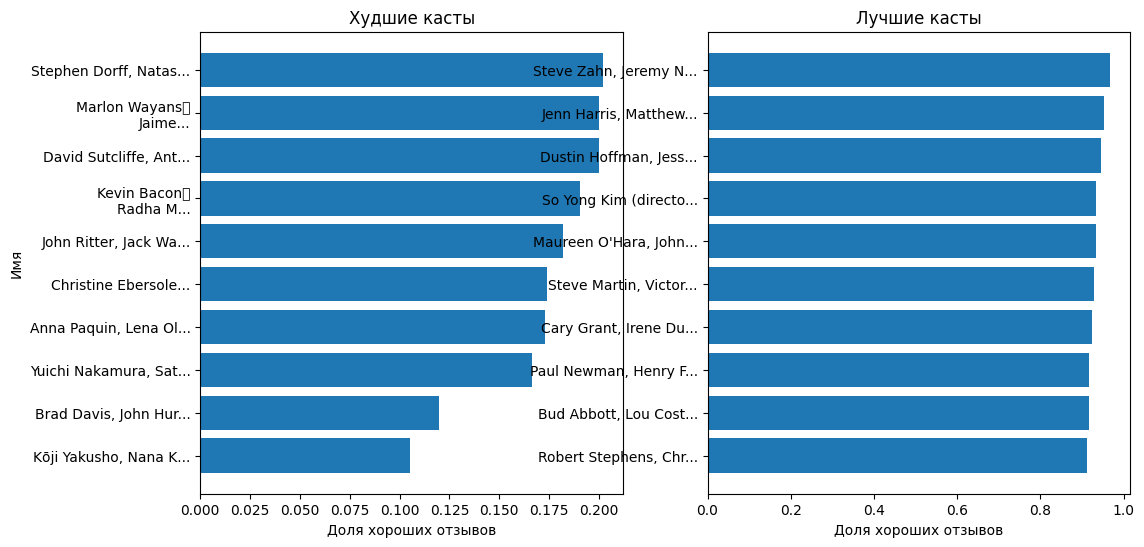

In [30]:
cast_best = df.groupby('Cast', as_index = False).positive_review.mean().sort_values(by = 'positive_review')[-10:]
cast_worst = df.groupby('Cast', as_index = False).positive_review.mean().sort_values(by = 'positive_review')[:10]
cast_best.Cast = cast_best.Cast.apply(lambda x: x[:20] + '...')
cast_worst.Cast = cast_worst.Cast.apply(lambda x: x[:20] + '...')

cast_best.index = cast_best.Cast
cast_worst.index = cast_worst.Cast

fig, axs = plt.subplots(1, 2, figsize =(12,6) )
axs[0].barh(cast_worst.index, cast_worst.positive_review)
axs[0].set(title='Худшие касты', ylabel= 'Имя', xlabel= 'Доля хороших отзывов')

axs[1].barh(cast_best.index, cast_best.positive_review)
axs[1].set(title = 'Лучшие касты', xlabel= 'Доля хороших отзывов', ylabel= '')

plt.show()

In [31]:
# Выберем жанры у которых больше 20 отзывов
df = data.groupby('Genre', as_index = False).Title.count()
df = pd.merge(data, df, on = 'Genre', how = 'inner').rename(columns = {'Title_x': 'Title', 'Title_y': 'review_on_genre'})
df = df[df['review_on_genre'] > 20]
df

,title,reviewText,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,Count,Release Year_5,GenreSplit,plot_sentiment,review_sentiment,positive_review,review_on_genre
0,Death of a Salesman,"Miller has taken a small, intimate tale and ex...",1951,Death of a Salesman,American,László Benedek,"Fredric March, Mildred Dunnock",drama,https://en.wikipedia.org/wiki/Death_of_a_Sales...,Willy Loman has led a life consisting of 60 ye...,1,1950-1954,['drama'],neu,neg,0,119623
1,Death of a Salesman,A classic American tragedy.,1951,Death of a Salesman,American,László Benedek,"Fredric March, Mildred Dunnock",drama,https://en.wikipedia.org/wiki/Death_of_a_Sales...,Willy Loman has led a life consisting of 60 ye...,1,1950-1954,['drama'],neu,neg,0,119623
2,Death of a Salesman,"Death of a Salesman, directed by Volker Schlon...",1951,Death of a Salesman,American,László Benedek,"Fredric March, Mildred Dunnock",drama,https://en.wikipedia.org/wiki/Death_of_a_Sales...,Willy Loman has led a life consisting of 60 ye...,1,1950-1954,['drama'],neu,pos,1,119623
3,Death of a Salesman,Schlndorff's artificial settings and some amaz...,1951,Death of a Salesman,American,László Benedek,"Fredric March, Mildred Dunnock",drama,https://en.wikipedia.org/wiki/Death_of_a_Sales...,Willy Loman has led a life consisting of 60 ye...,1,1950-1954,['drama'],neu,pos,1,119623
4,Death of a Salesman,They MAKE you watch it in English class for a ...,1951,Death of a Salesman,American,László Benedek,"Fredric March, Mildred Dunnock",drama,https://en.wikipedia.org/wiki/Death_of_a_Sales...,Willy Loman has led a life consisting of 60 ye...,1,1950-1954,['drama'],neu,pos,1,119623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802546,Hyena Road,The conflict between acting strategically from...,2015,Hyena Road,Canadian,Paul Gross,"Paul Gross, Rossif Sutherland, Clark Johnson, ...",afghan|action|drama,https://en.wikipedia.org/wiki/Hyena_Road,"In Kandahar Province, Afghanistan, the Canadia...",1,2015-2017,['action' 'afghan' 'drama'],neu,pos,1,23
802547,Hyena Road,The film acknowledges political and moral quan...,2015,Hyena Road,Canadian,Paul Gross,"Paul Gross, Rossif Sutherland, Clark Johnson, ...",afghan|action|drama,https://en.wikipedia.org/wiki/Hyena_Road,"In Kandahar Province, Afghanistan, the Canadia...",1,2015-2017,['action' 'afghan' 'drama'],neu,pos,1,23
802548,Hyena Road,Writer-director-star Paul Gross spent a lot of...,2015,Hyena Road,Canadian,Paul Gross,"Paul Gross, Rossif Sutherland, Clark Johnson, ...",afghan|action|drama,https://en.wikipedia.org/wiki/Hyena_Road,"In Kandahar Province, Afghanistan, the Canadia...",1,2015-2017,['action' 'afghan' 'drama'],neu,neg,0,23
802549,Hyena Road,An engrossing rebuttal to the sense that only ...,2015,Hyena Road,Canadian,Paul Gross,"Paul Gross, Rossif Sutherland, Clark Johnson, ...",afghan|action|drama,https://en.wikipedia.org/wiki/Hyena_Road,"In Kandahar Province, Afghanistan, the Canadia...",1,2015-2017,['action' 'afghan' 'drama'],neu,pos,1,23


Построим долю хороших отзывов по топ-10 лучшим жанрам и топ-10 худшим

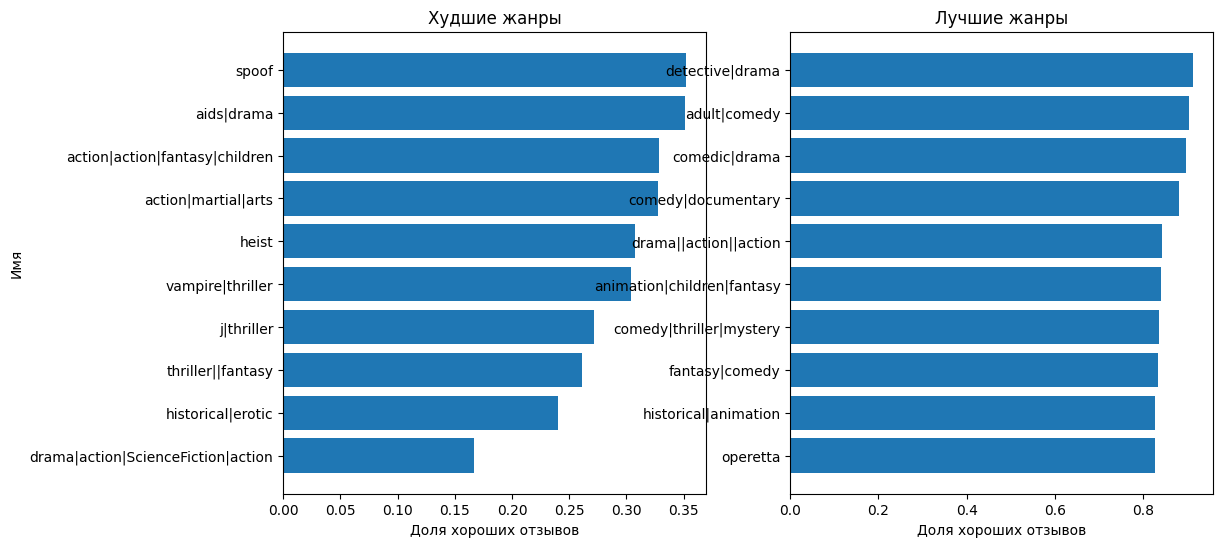

In [32]:
dir_best = df.groupby('Genre').positive_review.mean().sort_values()[-10:]
dir_worst = df.groupby('Genre').positive_review.mean().sort_values()[:10]

fig, axs = plt.subplots(1, 2, figsize =(12,6) )
axs[0].barh(dir_worst.index, dir_worst)
axs[0].set(title='Худшие жанры', ylabel= 'Имя', xlabel= 'Доля хороших отзывов')

axs[1].barh(dir_best.index, dir_best)
axs[1].set(title = 'Лучшие жанры', xlabel= 'Доля хороших отзывов', ylabel= '')

plt.show()